In [1]:
import os 
import math
import torch

import numpy as np
import pandas as pd
import torch.nn as nn
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data  import DataLoader
from transformers import AutoTokenizer, AutoModel, AdamW, get_cosine_schedule_with_warmup
from torchmetrics.functional.classification import auroc


c:\Users\incognito\miniconda3\envs\llm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_path = './data/small_train.csv'
val_path = './data/small_val.csv'


In [3]:
train_data = pd.read_csv(train_path)
train_data.head(5)

,_unit_id,_trusted_judgments,comment,antagonize,antagonize:confidence,condescending,condescending:confidence,dismissive,dismissive:confidence,generalisation,generalisation:confidence,generalisation_unfair,generalisation_unfair:confidence,healthy,healthy:confidence,hostile,hostile:confidence,sarcastic,sarcastic:confidence
0,2319157561,4,"Three marriages, several bankrupt periods, inh...",0,1.0000,0,1.0000,0,1.0000,0,1.0000,0.0,1.0,1,0.7578,0,0.7565,0,1.0000
1,1739464982,4,The sense of entitlement among high school 'jo...,0,0.7634,0,0.7634,0,0.7634,0,1.0000,0.0,1.0,1,0.7634,0,0.7634,0,0.7634
2,1739457583,5,So what? He was just stating the obvious.,0,0.8121,0,0.5928,0,0.8043,0,1.0000,0.0,1.0,1,0.6163,0,1.0000,0,1.0000
3,2319156950,40,"If one is a Con, why yes, one would honk. Loud...",0,0.8508,0,0.8867,0,0.9239,0,0.8863,0.0,1.0,1,0.8508,0,0.9641,0,0.8868
4,2327196492,3,Ooohhh... It's Wendy Whiner... making sure to ...,0,1.0000,0,1.0000,0,1.0000,0,1.0000,0.0,1.0,1,1.0000,0,1.0000,0,1.0000


In [4]:
len(train_data)

99

<Axes: >

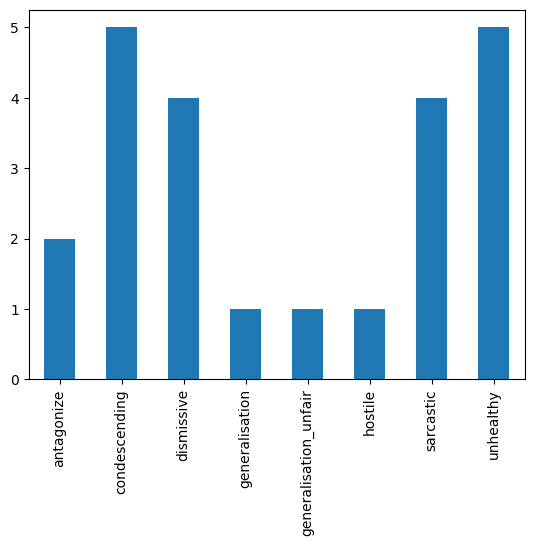

In [5]:
train_data['unhealthy'] = np.where(train_data['healthy'] == 1, 0,1 )
attributes =  ['antagonize', 'condescending', 'dismissive', 'generalisation',
               'generalisation_unfair', 'hostile', 'sarcastic', 'unhealthy']
train_data[attributes].sum().plot.bar()

In [6]:
class UCC_Dataset(Dataset):
    def __init__(self, data_path, tokenizer, attributes, 
               max_token_len:len=128, sample=50):
        self.data_path = data_path
        self.tokenizer = tokenizer
        self.attributes = attributes
        self.max_token_len = max_token_len
        self.sample = sample
        self._prepare_data()
        
    def _prepare_data(self):
        data = pd.read_csv(self.data_path)
        data['unhealthy'] = np.where(data['healthy']== 1,0,1)
        if self.sample is not None:
                unhealthy = data.loc[data[attributes].sum(axis=1) > 0]
                helathy = data.loc[data[attributes].sum(axis=1) == 0]
                self.data = pd.concat([unhealthy, helathy.sample(self.sample, random_state=7)])
        else:
                self.data = data
                
    def __len__(self):
            return len(self.data)
        
    def __getitem__(self, index):
            item = self.data.iloc[index]
            comment = str(item.comment)
            attributes = torch.FloatTensor(item[self.attributes])
            tokens = self.tokenizer.encode_plus(comment,
                                                add_special_tokens=True,
                                                return_tensors='pt',
                                                truncation=True,
                                                max_length=self.max_token_len,
                                                padding='max_length',
                                                return_attention_mask=True)
            return {'input_ids': tokens.input_ids.flatten(), 'attention_mask': tokens.attention_mask.flatten(), 'labels': attributes}
            

In [7]:
model_name = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
ucc_ds = UCC_Dataset(train_path, tokenizer, attributes)
ucc_ds_val = UCC_Dataset(val_path, tokenizer, attributes, sample=None)

c:\Users\incognito\miniconda3\envs\llm\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
ucc_ds.__getitem__(0)

C:\Users\incognito\AppData\Local\Temp\ipykernel_12304\1777664224.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  attributes = torch.FloatTensor(item[self.attributes])


{'input_ids': tensor([    0, 19897, 29846,     4,    38,    64,    75,   679, 46301,    74,
          9802,   132,     9,    39,   308,    95,     7,  1471,   559,   332,
             8,   146,  7064,   356,  1099,     4,   370,   214,   235,     6,
         46301,    16,    10, 34759,     4,     2,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,   

In [9]:
len(ucc_ds)

61

In [10]:
class UCC_Data_Module(pl.LightningDataModule):
    def __init__(self, train_path, val_path, attributes, batch_size: int =16, max_token_len: int = 128,
                 model_name= 'roberta-base'):
        super().__init__()
        self.train_path = train_path
        self.val_path = val_path
        self.attributes = attributes
        self.batch_size = batch_size
        self.max_token_len = max_token_len
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        
    def setup(self, stage = None):
        if stage in (None, "fit"):
            self.train_dataset = UCC_Dataset(self.train_path, self.tokenizer, self.attributes)
            self.val_dataset = UCC_Dataset(self.val_path, self.tokenizer, self.attributes, sample=None)
        if stage == 'predict':
            self.val_dataset = UCC_Dataset(self.val_path, self.tokenizer, self.attributes, sample=None)
            
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=4, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=4, shuffle=True)
    
    def predict_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=4)

In [11]:
ucc_data_module = UCC_Data_Module(train_path,val_path, attributes)

c:\Users\incognito\miniconda3\envs\llm\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [12]:
ucc_data_module.setup()

In [13]:
dl = ucc_data_module.train_dataloader()
len(dl)

4

In [14]:
from pickletools import optimize


class UCC_classifier(pl.LightningModule):
    def __init__(self, config: dict):
        super().__init__()
        self.config = config
        self.pretrained_model = AutoModel.from_pretrained(config['model_name'], return_dict = True)
        self.hidden = nn.Linear(self.pretrained_model.config.hidden_size, self.pretrained_model.config.hidden_size)
        self.classifier = nn.Linear(self.pretrained_model.config.hidden_size, self.config['n_labels'])
        torch.nn.init.xavier_uniform_(self.classifier.weight)
        torch.nn.init.xavier_uniform_(self.classifier.weight)
        self.loss_func = nn.BCEWithLogitsLoss(reduction='mean')
        self.dropout = nn.Dropout()
        
        
    def forward(self, input_ids, attention_mask, labels=None):
        # roberta model
        output = self.pretrained_model(input_ids = input_ids, attention_mask = attention_mask)
        pooled_output = torch.mean(output.last_hidden_state, 1)
        
        # feed forward classification layer
        hidden_output = self.hidden(pooled_output)
        dropout_ouput = self.dropout(hidden_output)
        relu_ouput = F.relu(dropout_ouput)
        logits = self.classifier(relu_ouput)
        
        loss = 0
        if labels is not None:
            loss = self.loss_func(logits.view(-1, self.config['n_labels']), labels.view(-1, self.config['n_labels']))
        return loss, logits
    
    
    def training_step(self, batch, batch_index):
        loss, logits = self(**batch)
        self.log("train loss", loss, prog_bar = True, logger = True)
        return {"loss" : loss, "predictions" : logits , "labels" : batch['labels']}
    
    def validation_step(self, batch, batch_index):
        loss, logits = self(**batch)
        self.log("validation loss", loss, prog_bar = True, logger = True)
        return {" val_loss" : loss, "predictions" : logits , "labels" : batch['labels']}
    
    def predict_step(self, batch, batch_index):
        _, logits = self(**batch)
        return logits
    
    def configure_optimizers(self):
        optimize = AdamW(self.parameters(), lr=self.config['lr'], weight_decay= self.config['w_decay'])
        total_steps = self.config['train_size'] / self.config['bs']
        warpup_steps = math.floor(total_steps * self.config['warmup'])
        schedular = get_cosine_schedule_with_warmup(optimize, warpup_steps, total_steps)
        return [optimize], [schedular]

In [15]:
config = {
    'model_name' : 'distilroberta-base',
    "n_labels" : len(attributes),
    'bs' : 128,
    'lr' : 1.5e-6,
    'warmup' : 0.2,
    'train_size' : len(ucc_data_module.train_dataloader()),
    'w_decay': 0.001,
    'n_epochs': 1 
}

model = UCC_classifier(config)

In [16]:
config['train_size']

4

In [17]:
idx = 0 
input_ids = ucc_ds.__getitem__(idx)['input_ids']
am = ucc_ds.__getitem__(idx)['attention_mask']
labels = ucc_ds.__getitem__(idx)['labels']
loss , output = model(input_ids.unsqueeze(dim=0), am.unsqueeze(dim=0), labels.unsqueeze(dim=0))

C:\Users\incognito\AppData\Local\Temp\ipykernel_12304\1777664224.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  attributes = torch.FloatTensor(item[self.attributes])
C:\Users\incognito\AppData\Local\Temp\ipykernel_12304\1777664224.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  attributes = torch.FloatTensor(item[self.attributes])
C:\Users\incognito\AppData\Local\Temp\ipykernel_12304\1777664224.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by positi

In [18]:
loss , output

(tensor(0.7425, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 tensor([[ 0.3527, -0.0519,  0.4863,  0.0287,  0.1433,  0.0543, -0.4591, -0.0851]],
        grad_fn=<AddmmBackward0>))

In [19]:
ucc_data_module = UCC_Data_Module(train_path, val_path, attributes, batch_size=config['bs'])
ucc_data_module.setup()

# model
model = UCC_classifier(config)

# train
trainer= pl.Trainer(max_epochs=config['n_epochs'])
trainer.fit(model, ucc_data_module)

c:\Users\incognito\miniconda3\envs\llm\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\incognito\miniconda3\envs\llm\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\incognito\miniconda3\envs\llm\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\incognito\miniconda3\envs\llm\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs/

In [ ]:
def classify_raw_comments(model, dm):
    predictions = trainer.predict(model,datamodule=dm)
    flattended_predictions = np.stack([torch.sigmoid(torch.Tensor(p)) for batch in predictions for p in batch])
    return flattended_predictions

predictions = classify_raw_comment(model, ucc_data_module)

In [ ]:
val_data = pd.read_csv(val_path)
val_data['unhealthy'] = np.where(val_data['healthy'] == 1, 0, 1)
true_labels = np.array(val_data[attributes])

In [ ]:
from sklearn import metrics
plt.figure(figsize=(15, 8))
for i, attribute in enumerate(attributes):
  fpr, tpr, _ = metrics.roc_curve(
      true_labels[:,i].astype(int), predictions[:, i])
  auc = metrics.roc_auc_score(
      true_labels[:,i].astype(int), predictions[:, i])
  plt.plot(fpr, tpr, label='%s %g' % (attribute, auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('RoBERTa Trained on UCC Datatset - AUC ROC')